# Extract features and Remove unimportant features

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

from helpers.plots import cluster, insights
from helpers import constants as C

### Import Datasets

In [2]:
data_path = Path("data/Gurgaon")

data_mapping = {
    "Res Apartment": pd.read_csv(data_path / "res_apartment.csv"),
    "Rent Apartment": pd.read_csv(data_path / "rent_apartment_house.csv"),
    "Ind Floor": pd.read_csv(data_path / "ind_floor.csv"),
    "Rent Ind Floor": pd.read_csv(data_path / "rent_ind_floor.csv"),
    "Ind House": pd.read_csv(data_path / "ind_house.csv"),
    "Res Land": pd.read_csv(data_path / "res_land.csv"),
}

In [3]:
cols_for_cluster = [
    "TOTAL_LANDMARK_COUNT",
    "TRANSPORATION",
    "ACCOMODATION",
    "LEISURE",
    "EDUCATION",
    "HEALTH",
    "OTHER",
    "AMENITIES_SCORE",
    "FEATURES_SCORE",
]

## General Step

In [4]:
for title, data in data_mapping.items():
    data_mapping[title] = data.applymap(
        lambda x: np.nan if x == "not available" or x == "Undefined" else x
    )

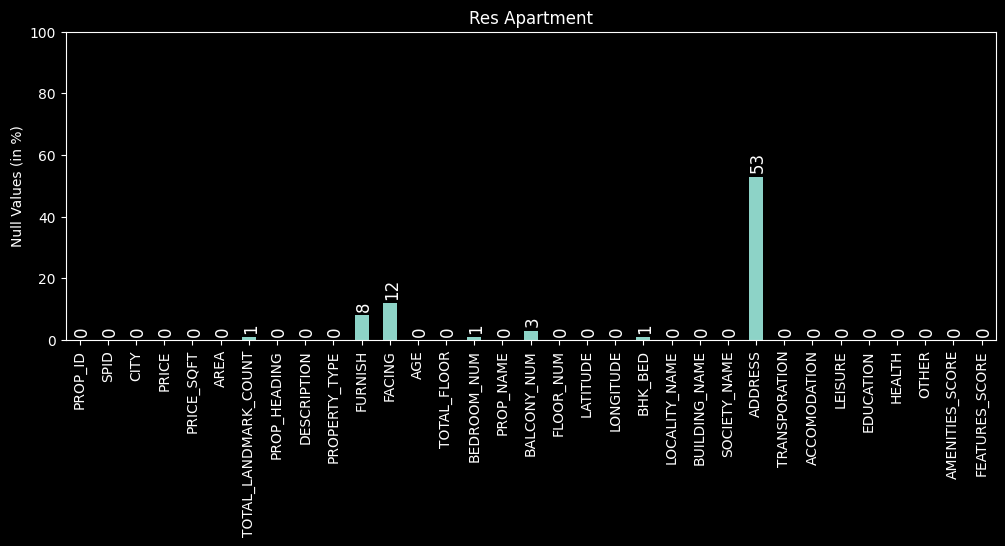

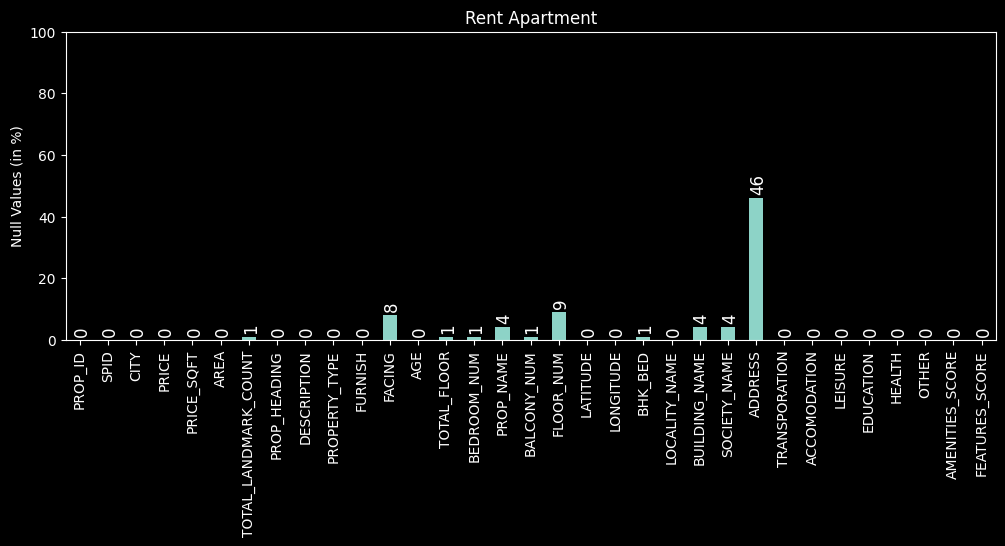

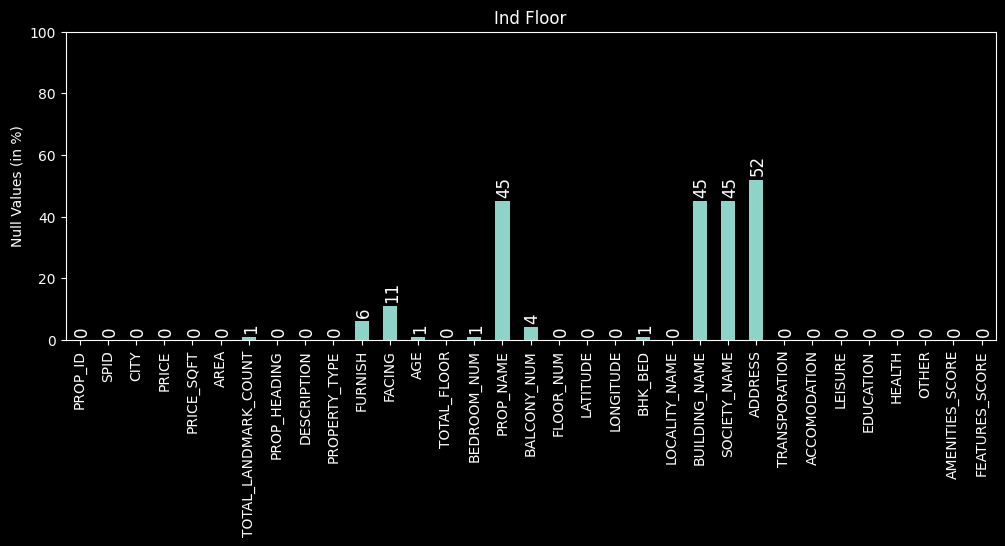

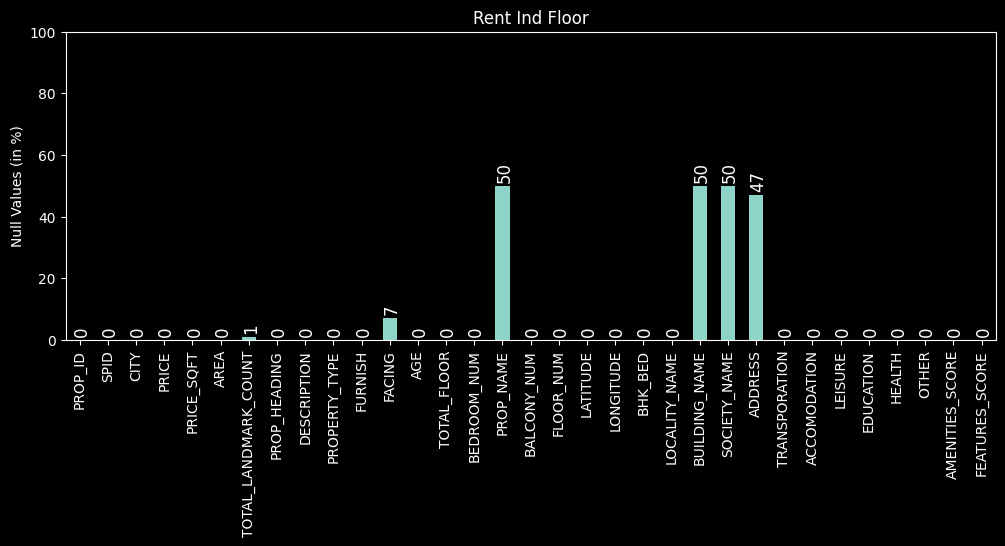

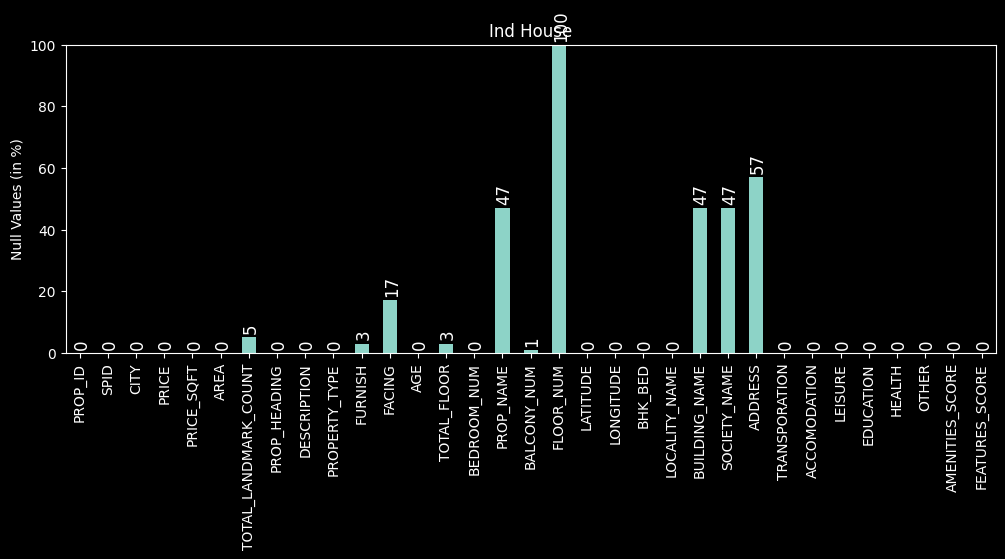

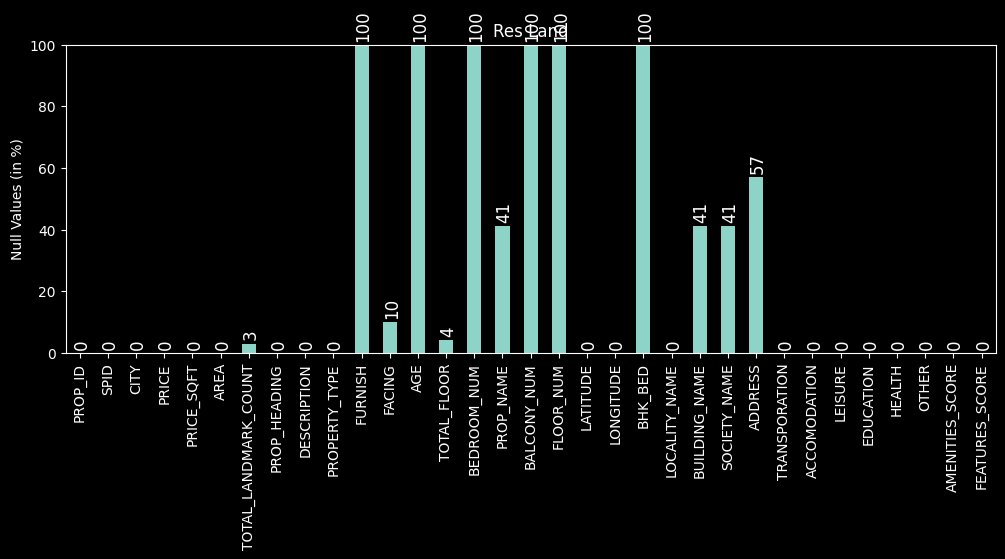

In [5]:
# Null Plot of every dataset
for title, data in data_mapping.items():
    plt.title(title)
    insights.null_plot(data)

## Create Clusters from features

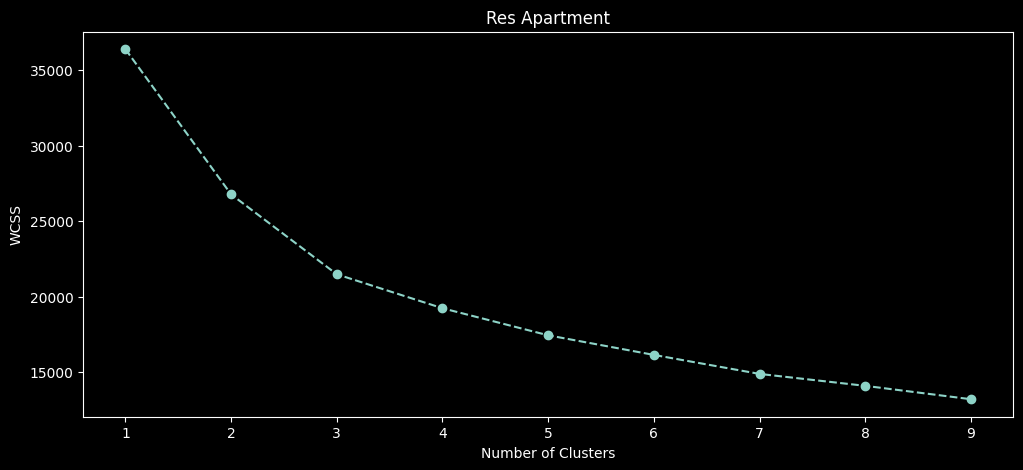

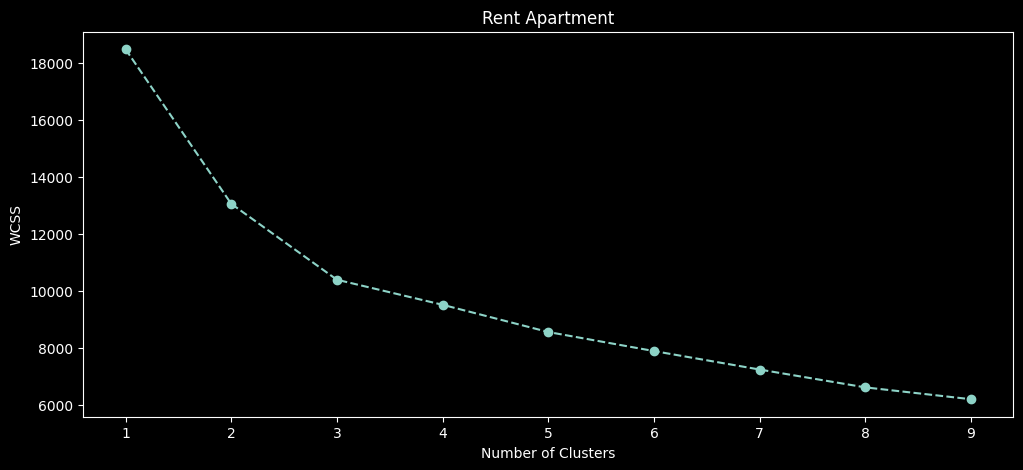

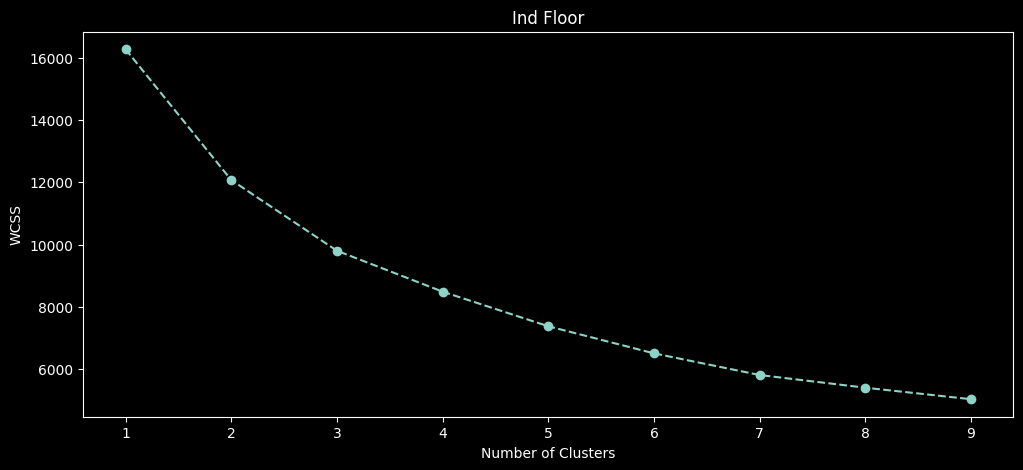

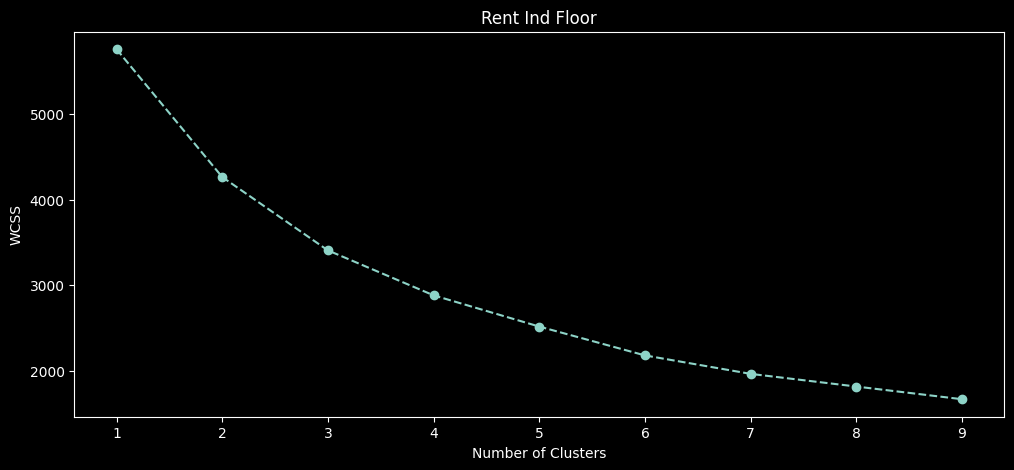

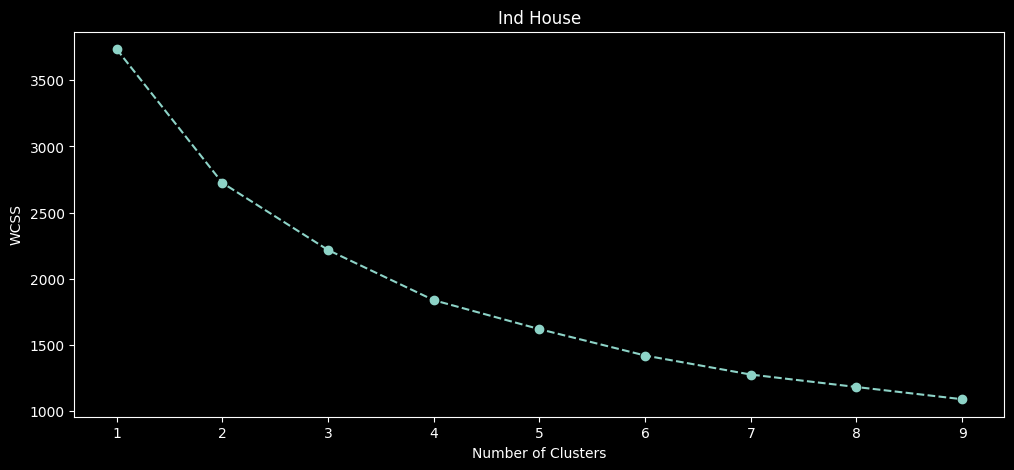

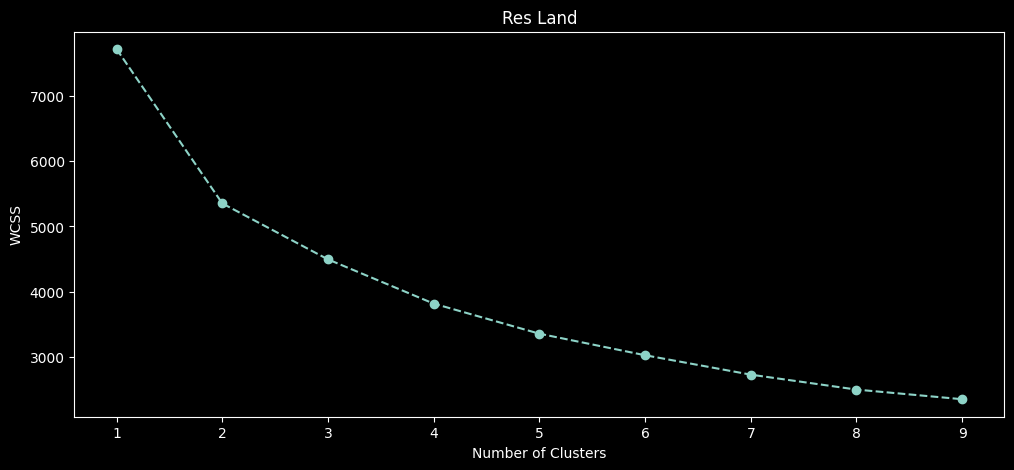

In [6]:
for title, data in data_mapping.items():
    scaler = StandardScaler()
    data_for_cluster = scaler.fit_transform(data[cols_for_cluster].dropna())
    wcss = cluster.find_optimal_clusters(data_for_cluster)

    # Plot the wcss values to figure out which cluster is best
    plt.figure(figsize=(12, 5))
    plt.title(title)
    cluster.plot_clusters(wcss, title=title)

- I am not going to create `"LUXURY_CATEGORY"` feature for **Independent House, Residential Land**.
- The optimal cluster for each dataset is 3 (which is expected).

In [7]:
for title, data in data_mapping.items():
    if title in ["Res Land", "Ind House"]:
        continue

    temp = data[cols_for_cluster].dropna()

    scaler = StandardScaler()
    data_for_cluster = scaler.fit_transform(temp)

    data.loc[temp.index, "LUXURY_CATEGORY"] = cluster.fit_kmeans_model(data_for_cluster, 3).predict(
        data_for_cluster
    )
    print(f"{title}\n-------\n{data['LUXURY_CATEGORY'].value_counts(dropna=False)}\n")

Res Apartment
-------
LUXURY_CATEGORY
2.0    2649
0.0    1027
1.0     368
NaN       5
Name: count, dtype: int64

Rent Apartment
-------
LUXURY_CATEGORY
2.0    1084
0.0     625
1.0     346
NaN       5
Name: count, dtype: int64

Ind Floor
-------
LUXURY_CATEGORY
1.0    658
0.0    588
2.0    563
NaN      7
Name: count, dtype: int64

Rent Ind Floor
-------
LUXURY_CATEGORY
0.0    304
1.0    207
2.0    129
NaN      2
Name: count, dtype: int64



## Residential Apartment

In [8]:
res_apartment = data_mapping["Res Apartment"]

In [9]:
# Drop unecessary columns/features from the dataset
drop_cols = [
    "SPID",
    "PRICE_SQFT",
    "TOTAL_FLOOR",
    "BHK_BED",
    "TOTAL_LANDMARK_COUNT",
    "TRANSPORATION",
    "ACCOMODATION",
    "LEISURE",
    "EDUCATION",
    "HEALTH",
    "OTHER",
    "AMENITIES_SCORE",
    "FEATURES_SCORE",
    "BUILDING_NAME",
]
res_apartment.drop(columns=drop_cols, inplace=True)

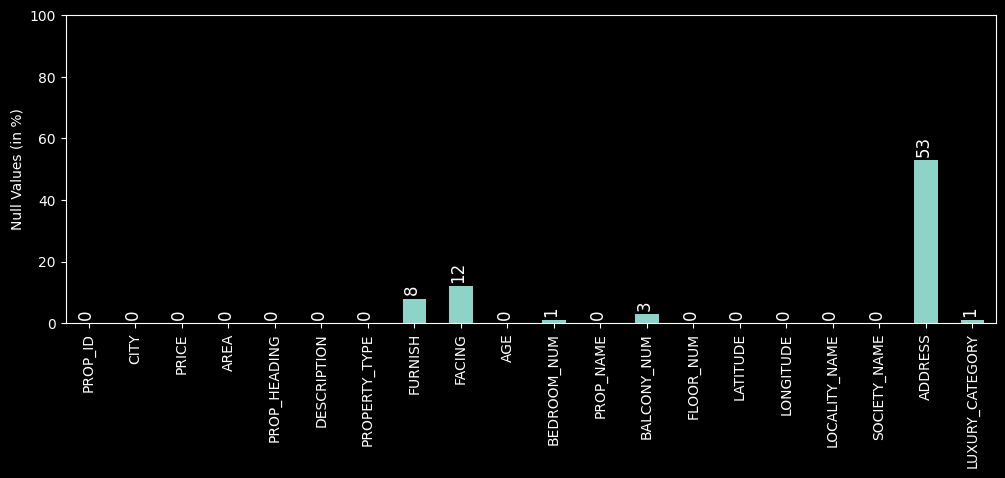

In [10]:
insights.null_plot(res_apartment)

### Missing Value Imputation

#### BEDROOM_NUM

In [11]:
res_apartment[res_apartment["BEDROOM_NUM"].isnull()]

,PROP_ID,CITY,PRICE,AREA,PROP_HEADING,DESCRIPTION,PROPERTY_TYPE,FURNISH,FACING,AGE,BEDROOM_NUM,PROP_NAME,BALCONY_NUM,FLOOR_NUM,LATITUDE,LONGITUDE,LOCALITY_NAME,SOCIETY_NAME,ADDRESS,LUXURY_CATEGORY
1962,v70102562,gurgaon,19500000.0,2000.0,flat in sector 102 gurgaon,just 30 minutes drive from delhi international...,residential apartment,Semifurnished,South-West,1-5 Year Old Property,NaN,emaar imperial gardens,NaN,mid rise,28.474697,76.968627,sector 102 gurgaon,emaar imperial gardens,NaN,2.0
2326,j69618808,gurgaon,23000000.0,2403.0,flat in sector 65 gurgaon,all facilities available very luxury,residential apartment,Semifurnished,North-East,1-5 Year Old Property,NaN,emaar emerald hills,NaN,low rise,28.405670,77.070837,sector 65 gurgaon,emaar emerald hills,103,0.0
2655,q70734058,gurgaon,27000000.0,2450.0,flat in sector 104 gurgaon,winner of the residential property of the year...,residential apartment,Semifurnished,North-East,1-5 Year Old Property,NaN,puri emerald bay,NaN,low rise,28.478780,76.995990,sector 104 gurgaon,puri emerald bay,NaN,2.0


In [12]:
res_apartment["BEDROOM_NUM"].fillna(res_apartment["BEDROOM_NUM"].mode()[0], inplace=True)

#### BALCONY_NUM

In [13]:
temp = res_apartment[res_apartment["BALCONY_NUM"].isnull()]
temp.shape

(96, 20)

In [14]:
temp_mapping = res_apartment.pivot_table("BALCONY_NUM", "BEDROOM_NUM", aggfunc="median").to_dict()[
    "BALCONY_NUM"
]
temp_mapping

{1.0: 1.0, 2.0: 3.0, 3.0: 3.0, 4.0: 4.0, 5.0: 4.0, 6.0: 4.0}

In [15]:
temp["BEDROOM_NUM"].value_counts()

BEDROOM_NUM
3.0    44
4.0    32
2.0    16
5.0     4
Name: count, dtype: int64

In [16]:
res_apartment.loc[temp.index, "BALCONY_NUM"] = res_apartment.loc[temp.index, "BEDROOM_NUM"].map(
    temp_mapping
)

#### FURNISH

In [17]:
temp = res_apartment[res_apartment["FURNISH"].isnull()]
temp.shape

(286, 20)

In [18]:
temp_mapping = res_apartment.pivot_table("PRICE", "FURNISH", aggfunc="median")
temp_mapping.div(C.LAKH)

,PRICE
FURNISH,
Furnished,195.0
Semifurnished,220.0
Unfurnished,150.0


In [19]:
res_apartment.loc[temp.index, "FURNISH"] = (
    res_apartment.loc[temp.index, "PRICE"]
    .div(C.LAKH)
    .apply(
        lambda x: "Furnished" if x >= 220 else "Semifurnished" if 150 <= x < 220 else "Unfurnished"
    )
)
res_apartment["FURNISH"].value_counts()

FURNISH
Semifurnished    2920
Unfurnished       785
Furnished         344
Name: count, dtype: int64

#### FACING

In [20]:
temp = res_apartment[res_apartment["FACING"].isnull()]
temp.shape

(480, 20)

In [21]:
res_apartment["FACING"].value_counts()

FACING
North-East    1428
East           905
North          580
West           179
South-East     167
North-West     115
South          110
South-West      85
Name: count, dtype: int64

In [22]:
# Impute FACING feature with mode
res_apartment["FACING"].fillna(res_apartment["FACING"].mode()[0], inplace=True)
res_apartment["FACING"].value_counts()

FACING
North-East    1908
East           905
North          580
West           179
South-East     167
North-West     115
South          110
South-West      85
Name: count, dtype: int64

#### LUXURY_CATEGORY

In [23]:
res_apartment["LUXURY_CATEGORY"].fillna(res_apartment["LUXURY_CATEGORY"].mode()[0], inplace=True)

### Dataset insights

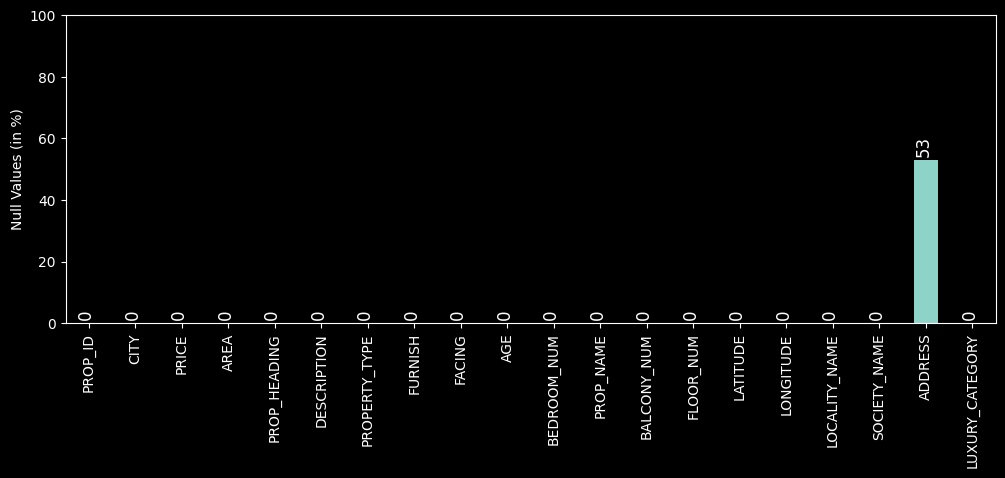

In [24]:
insights.null_plot(res_apartment)

In [25]:
res_apartment.to_csv("data/processed/Gurgaon/res_apartment.csv", index=False)

## Rental Apartment

In [26]:
rent_apartment = data_mapping["Rent Apartment"]

In [27]:
# Use res_apartment's drop_cols variable
rent_apartment.drop(columns=drop_cols, inplace=True)

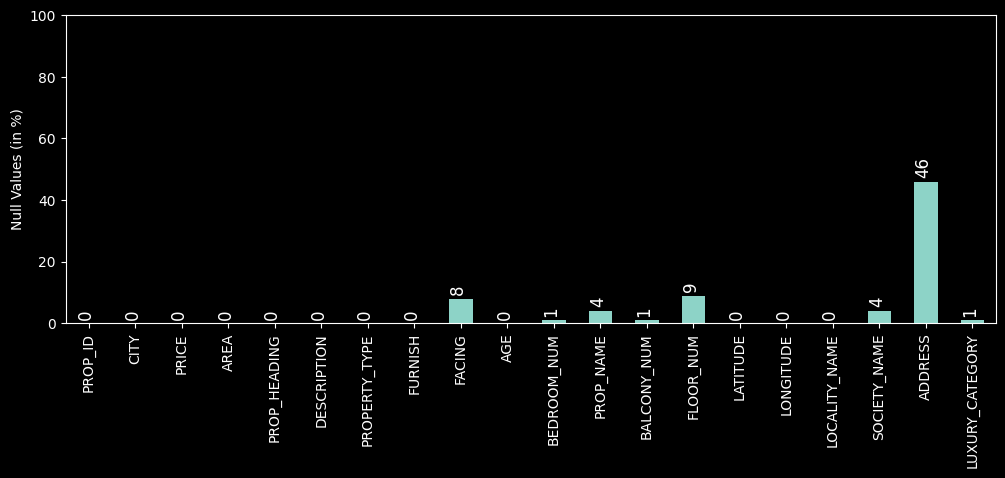

In [28]:
insights.null_plot(rent_apartment)

### Missing Value Imputation

#### BEDROOM_NUM

In [29]:
rent_apartment[rent_apartment["BEDROOM_NUM"].isnull()]

,PROP_ID,CITY,PRICE,AREA,PROP_HEADING,DESCRIPTION,PROPERTY_TYPE,FURNISH,FACING,AGE,BEDROOM_NUM,PROP_NAME,BALCONY_NUM,FLOOR_NUM,LATITUDE,LONGITUDE,LOCALITY_NAME,SOCIETY_NAME,ADDRESS,LUXURY_CATEGORY
825,x70719908,gurgaon,63000.0,2350.0,flat in sector 67 gurgaon,available for rent 4bhk in bestech spa next se...,residential apartment,Semifurnished,North-East,1-5 Year Old Property,NaN,bestech park view spa next,NaN,mid rise,28.386048,77.060764,sector 67 gurgaon,bestech park view spa next,401,2.0
1511,p70857446,gurgaon,40000.0,3198.0,flat in sector 102 gurgaon,best society for family on dwarka expressway,residential apartment,Semifurnished,North-East,1-5 Year Old Property,NaN,adani m2k oyster grande,NaN,low rise,28.474697,76.968627,sector 102 gurgaon,adani m2k oyster grande,NaN,0.0


In [30]:
rent_apartment["BEDROOM_NUM"].fillna(rent_apartment["BEDROOM_NUM"].mode()[0], inplace=True)

#### BALCONY_NUM

In [31]:
temp = rent_apartment[rent_apartment["BALCONY_NUM"].isnull()]
temp.shape

(3, 20)

In [32]:
temp_mapping = rent_apartment.pivot_table("BALCONY_NUM", "BEDROOM_NUM", aggfunc="median").to_dict()[
    "BALCONY_NUM"
]
temp_mapping

{1.0: 1.0,
 2.0: 2.0,
 3.0: 3.0,
 4.0: 4.0,
 5.0: 4.0,
 6.0: 4.0,
 7.0: 3.0,
 8.0: 2.0,
 10.0: 4.0,
 11.0: 4.0,
 12.0: 4.0,
 13.0: 4.0,
 16.0: 4.0,
 35.0: 4.0}

In [33]:
temp["BEDROOM_NUM"].value_counts()

BEDROOM_NUM
3.0    2
2.0    1
Name: count, dtype: int64

In [34]:
rent_apartment.loc[temp.index, "BALCONY_NUM"] = rent_apartment.loc[temp.index, "BEDROOM_NUM"].map(
    temp_mapping
)

#### FACING

In [35]:
temp = rent_apartment[rent_apartment["FACING"].isnull()]
temp.shape

(155, 20)

In [36]:
rent_apartment["FACING"].value_counts()

FACING
North-East    923
East          451
North         268
West           82
South-East     62
North-West     47
South          41
South-West     31
Name: count, dtype: int64

In [37]:
# Impute FACING feature with mode
rent_apartment["FACING"].fillna(rent_apartment["FACING"].mode()[0], inplace=True)
rent_apartment["FACING"].value_counts()

FACING
North-East    1078
East           451
North          268
West            82
South-East      62
North-West      47
South           41
South-West      31
Name: count, dtype: int64

#### FLOOR_NUM

In [38]:
rent_apartment["FLOOR_NUM"].value_counts(dropna=False)

FLOOR_NUM
mid rise     1045
high rise     542
low rise      295
NaN           178
Name: count, dtype: int64

In [39]:
# Impute with mode
rent_apartment["FLOOR_NUM"].fillna(rent_apartment["FLOOR_NUM"].mode()[0], inplace=True)

#### LUXURY_CATEGORY

In [40]:
rent_apartment["LUXURY_CATEGORY"].fillna(rent_apartment["LUXURY_CATEGORY"].mode()[0], inplace=True)

### Dataset insights

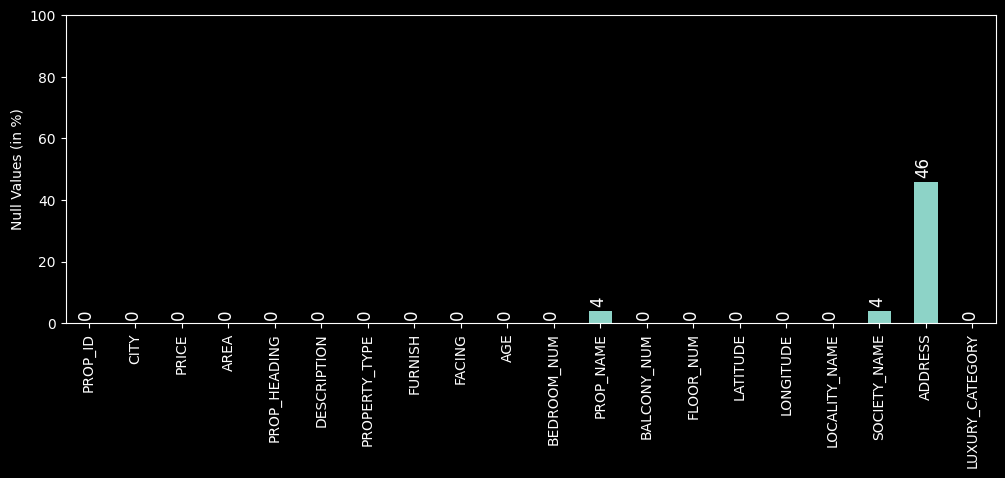

In [41]:
insights.null_plot(rent_apartment)

In [42]:
rent_apartment.to_csv("data/processed/Gurgaon/rent_apartment.csv", index=False)

## Independent Floors

In [43]:
ind_floor = data_mapping["Ind Floor"]

In [44]:
# Use res_apartment's drop_cols variable
ind_floor.drop(columns=drop_cols, inplace=True)

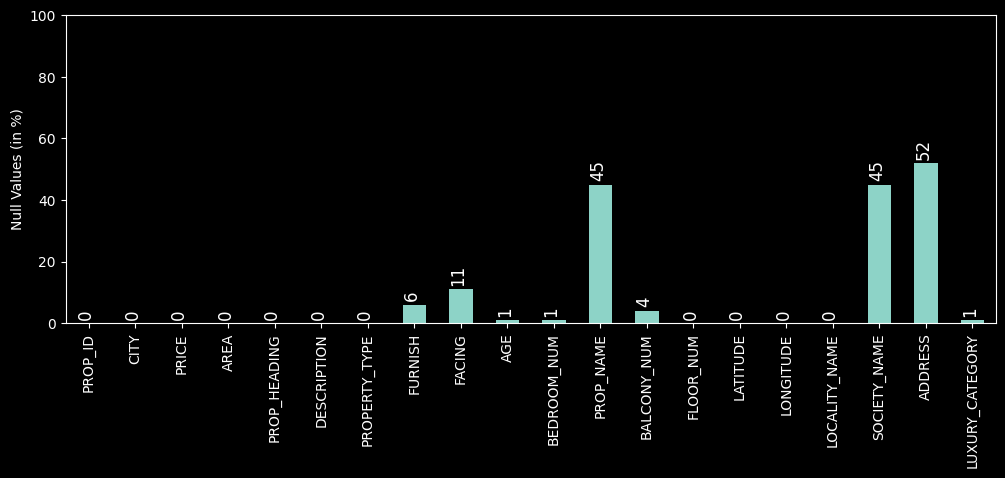

In [45]:
insights.null_plot(ind_floor)

### Missing Value Imputation

#### AGE, BEDROOM_NUM, BALCONY_NUM, FACING

In [46]:
for i in ["AGE", "BEDROOM_NUM", "BALCONY_NUM", "FACING"]:
    ind_floor[i].fillna(ind_floor[i].mode()[0], inplace=True)

#### FURNISH

In [47]:
temp = ind_floor[ind_floor["FURNISH"].isnull()]
temp.shape

(99, 20)

In [48]:
temp_mapping = ind_floor.pivot_table("PRICE", "FURNISH", aggfunc="median")
temp_mapping.div(C.LAKH)

,PRICE
FURNISH,
Furnished,215.5
Semifurnished,230.0
Unfurnished,189.0


In [49]:
ind_floor.loc[temp.index, "FURNISH"] = (
    ind_floor.loc[temp.index, "PRICE"]
    .div(C.LAKH)
    .apply(
        lambda x: "Furnished" if x >= 215 else "Semifurnished" if 190 <= x < 215 else "Unfurnished"
    )
)
ind_floor["FURNISH"].value_counts()

FURNISH
Semifurnished    1510
Furnished         177
Unfurnished       129
Name: count, dtype: int64

#### LUXURY_CATEGORY

In [50]:
ind_floor["LUXURY_CATEGORY"].fillna(ind_floor["LUXURY_CATEGORY"].mode()[0], inplace=True)

### Dataset insights

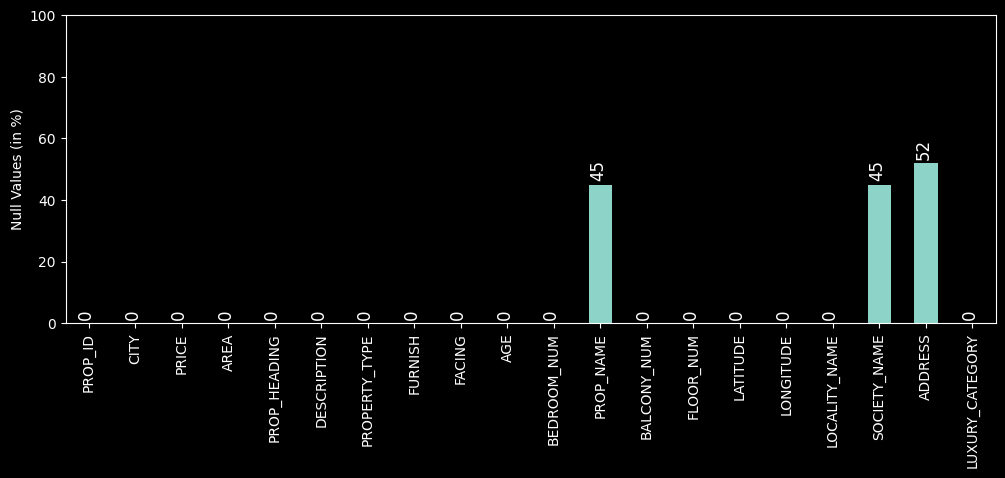

In [51]:
insights.null_plot(ind_floor)

In [52]:
ind_floor.to_csv("data/processed/Gurgaon/ind_floor.csv", index=False)

## Rental Independent Floors

In [53]:
rent_ind_floor = data_mapping["Rent Ind Floor"]

In [54]:
# Use res_apartment's drop_cols variable
rent_ind_floor.drop(columns=drop_cols, inplace=True)

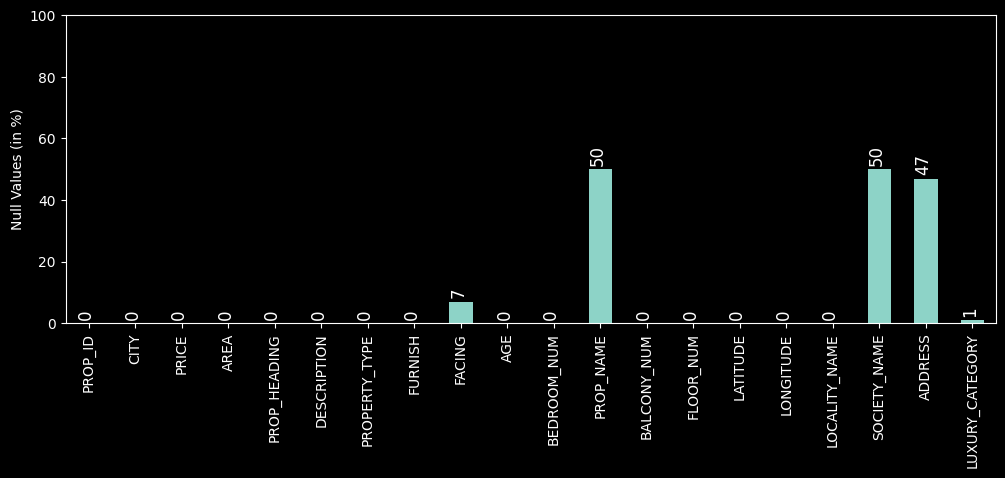

In [55]:
insights.null_plot(rent_ind_floor)

### Missing Value Imputation

#### FACING

In [56]:
rent_ind_floor["FACING"].fillna(rent_ind_floor["FACING"].mode()[0], inplace=True)

#### LUXURY_CATEGORY

In [57]:
rent_ind_floor["LUXURY_CATEGORY"].fillna(rent_ind_floor["LUXURY_CATEGORY"].mode()[0], inplace=True)

### Dataset insights

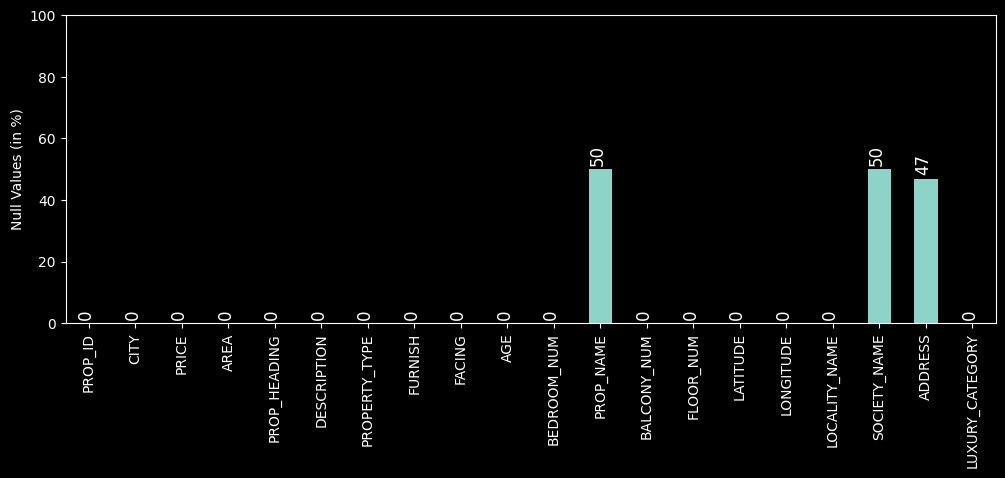

In [58]:
insights.null_plot(rent_ind_floor)

In [59]:
rent_ind_floor.to_csv("data/processed/Gurgaon/rent_ind_floor.csv", index=False)

## Independent House

In [60]:
ind_house = data_mapping["Ind House"]

In [61]:
# Use res_apartment's drop_cols variable
ind_house.drop(columns=drop_cols + ["FLOOR_NUM"], inplace=True)

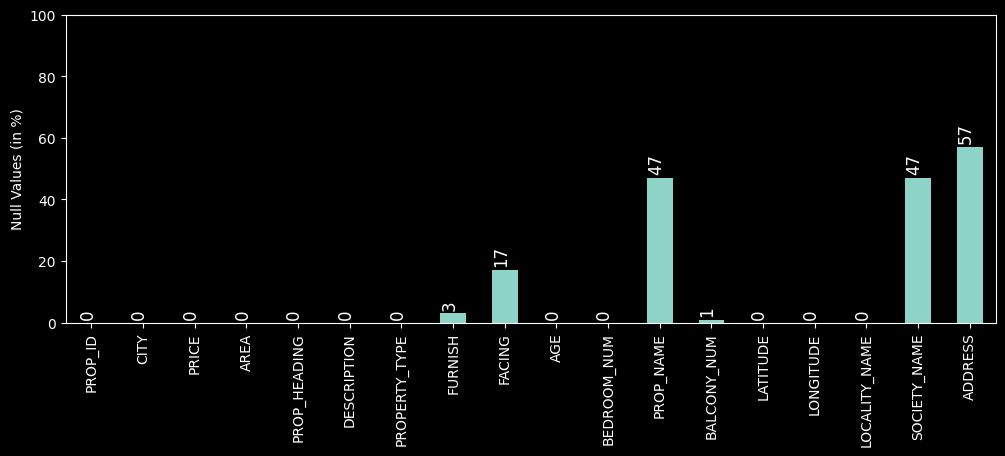

In [62]:
insights.null_plot(ind_house)

### Missing Value Imputation

#### BALCONY_NUM, FACING

In [63]:
for i in ["BALCONY_NUM", "FACING"]:
    ind_house[i].fillna(ind_house[i].mode()[0], inplace=True)

#### FURNISH

In [64]:
temp = ind_house[ind_house["FURNISH"].isnull()]
temp.shape

(12, 18)

In [65]:
temp_mapping = ind_house.pivot_table("PRICE", "FURNISH", aggfunc="median")
temp_mapping.div(C.LAKH)

,PRICE
FURNISH,
Furnished,320.0
Semifurnished,600.0
Unfurnished,640.0


The PRICE of furnished houses is not as expected; that's why I am going to impute it with **mode** value.

In [66]:
ind_house["FURNISH"].fillna(ind_house["FURNISH"].mode()[0], inplace=True)

### Dataset insights

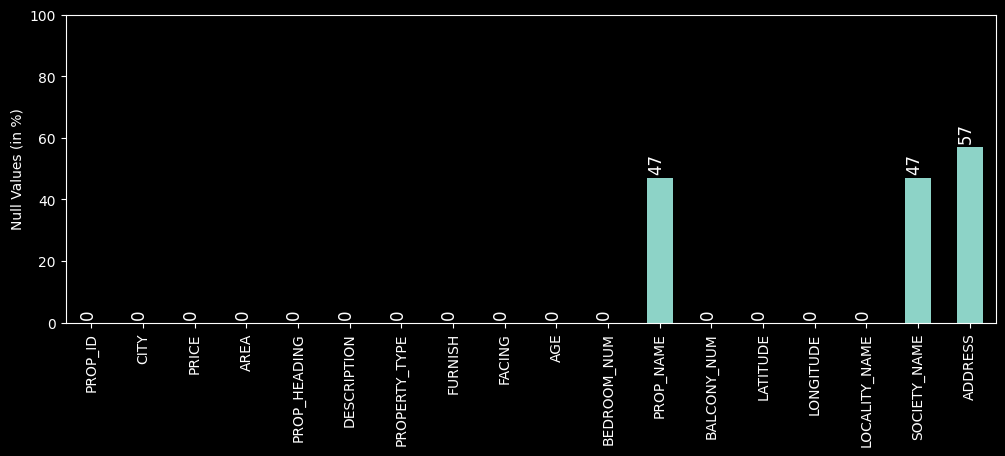

In [67]:
insights.null_plot(ind_house)

In [68]:
ind_house.to_csv("data/processed/Gurgaon/ind_house.csv", index=False)

## Residential Lands

In [69]:
res_land = data_mapping["Res Land"]

In [70]:
res_land.drop(
    columns=drop_cols + "AGE FACING FURNISH BEDROOM_NUM BALCONY_NUM FLOOR_NUM".split(),
    inplace=True,
    errors="ignore",
)

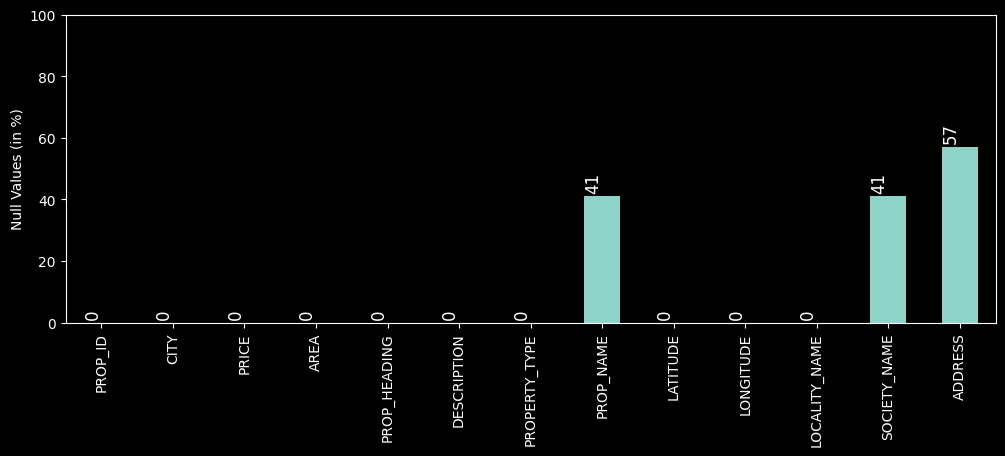

In [71]:
insights.null_plot(res_land)

In [72]:
res_land.to_csv("data/processed/Gurgaon/res_land.csv", index=False)

# Ready for model building